# Step 1

In [40]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import re
from itunes_app_scraper.scraper import AppStoreScraper
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

url = "https://fabiosacerdote.github.io/ScrapingData/top_paid_apps_to_share.html"

In [24]:
def scrape_apps_id(url:str):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")

    rows = []
    for tr in soup.select("tr"):
        tds = [td.get_text(strip=True) for td in tr.find_all("td")]
        if len(tds) >= 3:
            id_raw, rank_raw, name = tds[0], tds[1], tds[2]

            # Extract digits using regex
            id_digits = re.sub(r"\D+", "", id_raw)
            rank_digits = re.sub(r"\D+", "", rank_raw)

            if id_digits and rank_digits and name:
                rows.append((int(rank_digits), name, int(id_digits)))


    df_step1 = pd.DataFrame(rows, columns=["rank", "name", "id"])

    return df_step1

# Step 2 

In [25]:
df_step1 = scrape_apps_id(url)

In [26]:
scraper = AppStoreScraper()
def get_selected_app_details(app_ids, country="us", lang="en"):
    """Fetch only the wanted fields for a list of app IDs."""
    details = scraper.get_multiple_app_details(app_ids, country=country, lang=lang, sleep=0)

    rows = []
    for d in details:
        if not d:
            continue
        rows.append({
            "id": d.get("trackId"),
            "price": d.get("price"),
            "currency": d.get("currency"),
            "genre": d.get("primaryGenreName"),
            "avg_score": d.get("averageUserRating") or d.get("averageUserRatingForCurrentVersion"),
            "reviews_count": d.get("userRatingCount") or d.get("userRatingCountForCurrentVersion"),
            "developer": d.get("artistName")
        })
    return pd.DataFrame(rows)



In [27]:
ids = df_step1["id"].dropna().astype(int).tolist()
details_df = get_selected_app_details(ids)
fulldf = df_step1.merge(details_df, on="id", how="left")

fulldf

,rank,name,id,price,currency,genre,avg_score,reviews_count,developer
0,1,Minecraft: Play with Friends,479516143,6.99,USD,Games,4.50140,773353.0,Mojang
1,2,Bloons TD 6,1118115766,6.99,USD,Games,4.85886,325035.0,Ninja Kiwi
2,3,TurboScan™ Pro: PDF scanner,342548956,9.99,USD,Business,4.92556,289673.0,Piksoft Inc.
3,4,Heads Up!,623592465,1.99,USD,Games,4.79244,260554.0,Warner Bros.
4,5,Geometry Dash,625334537,2.99,USD,Games,4.52799,223365.0,RobTop Games AB
...,...,...,...,...,...,...,...,...,...
495,496,iMPC Pro 2 for iPhone,1413887036,12.99,USD,Music,4.65693,1781.0,Akai Professional
496,497,VinoCell - wine cellar manager,521577043,9.99,USD,Food & Drink,4.64821,1788.0,VinoDev
497,498,AnatomyMapp,510119487,9.99,USD,Medical,4.80842,1947.0,Books of Discovery
498,499,Cs Music Pro,924491991,2.99,USD,Music,4.30230,1783.0,Mike Clay


# Step 3

In [28]:
#assumption of 20 downloads per review
fulldf["estimated_downloads"] = fulldf["reviews_count"] * 20

Check the relation between dosnloads and rank, as the rank should be a good proxy for the number of downloads

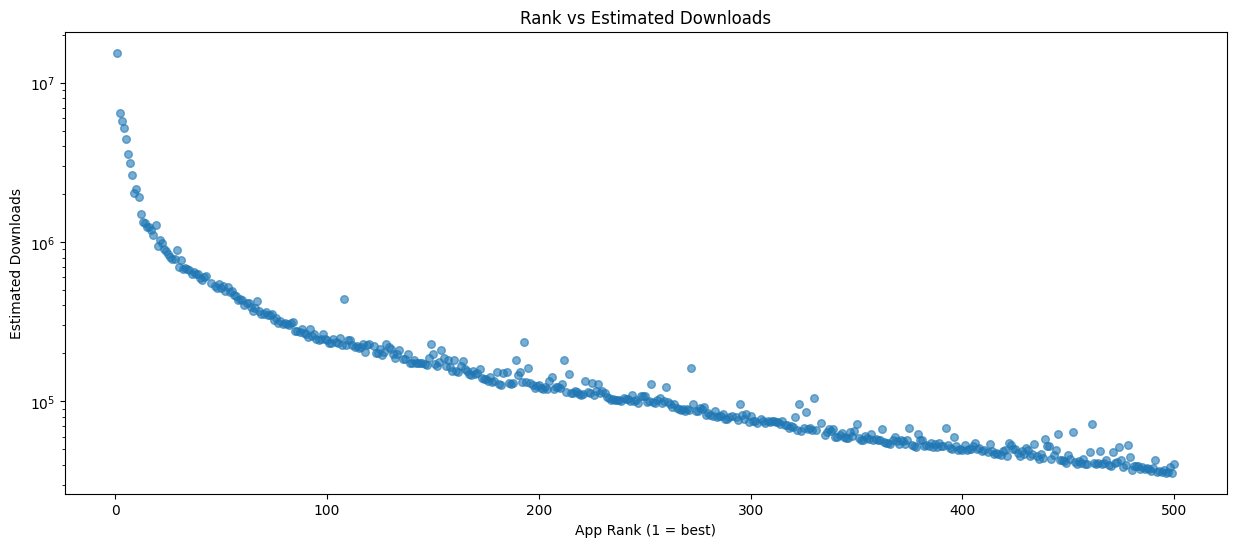

In [35]:
fig = plt.figure(figsize=(15, 6))
plt.scatter(fulldf['rank'], fulldf['estimated_downloads'], alpha=0.6, s=30)
plt.xlabel('App Rank (1 = best)')
plt.ylabel('Estimated Downloads')
plt.title('Rank vs Estimated Downloads')
plt.yscale('log')
plt.show()


Now map categories into macrocategories to have less than 10 cathegories

In [36]:
category_counts = fulldf["genre"].value_counts()
print(category_counts)

genre
Games                214
Photo & Video         38
Health & Fitness      28
Utilities             20
Productivity          19
Weather               18
Education             16
Music                 15
Lifestyle             15
Reference             14
Travel                13
Entertainment         13
Navigation            12
Business              11
Medical               10
Finance                9
Social Networking      8
Food & Drink           6
Shopping               5
Sports                 4
News                   2
Name: count, dtype: int64


In [37]:
#Define macro-categories mapping
macro_map = {
    "Games": "Games",
    "Entertainment": "Entertainment",
    "Music": "Entertainment",
    "Photo & Video": "Entertainment",
    "Social Networking": "Social",
    "Shopping": "E-commerce",
    "Food & Drink": "Lifestyle",
    "Health & Fitness": "Lifestyle",
    "Lifestyle": "Lifestyle",
    "Travel": "Travel",
    "Navigation": "Travel",
    "Business": "Productivity",
    "Productivity": "Productivity",
    "Utilities": "Productivity",
    "Finance": "Finance",
    "Medical": "Health",
    "Reference": "Education",
    "Education": "Education",
    "Weather": "Weather",
    "Sports": "Sports",
    "News": "News"
}
fulldf["macro_category"] = fulldf["genre"].map(macro_map)
macro_counts = fulldf.groupby("macro_category").size().sort_values(ascending=False)

outside_good = fulldf.groupby("genre").size()[lambda x: x < 10]

fulldf["final_category"] = fulldf.apply(
    lambda row: "Outside Good" if row["genre"] in outside_good.index else row["macro_category"],
    axis=1
)

final_counts = fulldf["final_category"].value_counts()
print(final_counts)
fulldf

final_category
Games            214
Entertainment     66
Productivity      50
Lifestyle         43
Outside Good      34
Education         30
Travel            25
Weather           18
Health            10
Name: count, dtype: int64


,rank,name,id,price,currency,genre,avg_score,reviews_count,developer,estimated_downloads,macro_category,final_category
0,1,Minecraft: Play with Friends,479516143,6.99,USD,Games,4.50140,773353.0,Mojang,15467060.0,Games,Games
1,2,Bloons TD 6,1118115766,6.99,USD,Games,4.85886,325035.0,Ninja Kiwi,6500700.0,Games,Games
2,3,TurboScan™ Pro: PDF scanner,342548956,9.99,USD,Business,4.92556,289673.0,Piksoft Inc.,5793460.0,Productivity,Productivity
3,4,Heads Up!,623592465,1.99,USD,Games,4.79244,260554.0,Warner Bros.,5211080.0,Games,Games
4,5,Geometry Dash,625334537,2.99,USD,Games,4.52799,223365.0,RobTop Games AB,4467300.0,Games,Games
...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,iMPC Pro 2 for iPhone,1413887036,12.99,USD,Music,4.65693,1781.0,Akai Professional,35620.0,Entertainment,Entertainment
496,497,VinoCell - wine cellar manager,521577043,9.99,USD,Food & Drink,4.64821,1788.0,VinoDev,35760.0,Lifestyle,Outside Good
497,498,AnatomyMapp,510119487,9.99,USD,Medical,4.80842,1947.0,Books of Discovery,38940.0,Health,Health
498,499,Cs Music Pro,924491991,2.99,USD,Music,4.30230,1783.0,Mike Clay,35660.0,Entertainment,Entertainment


In [39]:
fulldf.to_csv("apple_processed.csv", index=False)

# Statistics and tables

In [48]:
numeric_df = fulldf.select_dtypes(include=[np.number]).drop(columns=['rank', 'id'], errors='ignore')

#mean, median, std, min, max, count
summary = pd.DataFrame({
    "mean": numeric_df.mean(),
    "median": numeric_df.median(),
    "std": numeric_df.std(),
    "min": numeric_df.min(),
    "max": numeric_df.max(),
    "count": numeric_df.count()
})
summary = summary[["mean", "median", "std", "min", "max", "count"]]
summary = summary.round(2)
summary



,mean,median,std,min,max,count
price,6.21,4.99,6.92,0.00,59.99,490
avg_score,4.63,4.72,0.29,2.87,4.96,490
reviews_count,14251.77,5096.50,45473.26,1781.00,773353.00,490
estimated_downloads,285035.39,101930.00,909465.11,35620.00,15467060.00,490


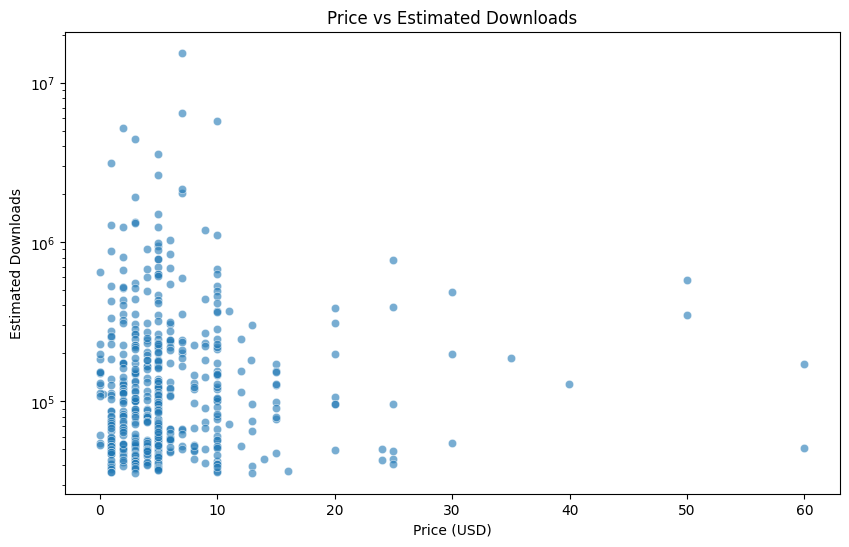

In [49]:
#Scatter plot for price vs estimated downloads
plt.figure(figsize=(10, 6))
sns.scatterplot(data=fulldf, x='price', y='estimated_downloads', alpha=0.6)
plt.yscale('log')
plt.xlabel('Price (USD)')
plt.ylabel('Estimated Downloads')
plt.title('Price vs Estimated Downloads')
plt.show()